<a href="https://colab.research.google.com/github/ozlemakboyraz/Brain-Classification-Project/blob/main/Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, models, transforms

# 1. GPU Kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")

Kullanılan Cihaz: cuda


In [7]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!cp "/content/drive/MyDrive/brain-dataset/Dataset_224x224.rar" /content/
!unrar x /content/Dataset_224x224.rar /content/

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0713.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0714.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0715.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0716.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0717.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0718.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0719.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0720.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0721.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0722.jpg       26%  OK 
Extracting  /content/Dataset_224x

In [9]:
# 2. Veri Yolları ve Parametreler
DATA_DIR = '/content//Dataset_224x224' # Kendi yolunla güncelle
TRAIN_DIR = os.path.join(DATA_DIR, 'Training')
TEST_DIR = os.path.join(DATA_DIR, 'Testing')

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS_PER_FOLD = 10  # Cross-validation uzun sürdüğü için makul bir sayı

In [10]:
# 3. Data Augmentation ve Normalizasyon
# MRI için Mean/Std (Genelde ImageNet değerleri transfer learning için tercih edilir)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [11]:
# 4. Model Oluşturma ve Katman Dondurma Fonksiyonu
def get_resnet_model():
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

    # %40 Katman Dondurma Stratejisi
    # ResNet50'de layer1 ve öncesini dondurmak yaklaşık %35-40 dondurma sağlar
    for param in model.parameters():
        param.requires_grad = False

    # Layer 2, 3, 4 ve FC katmanlarını eğitime açıyoruz (%60 civarı)
    for param in model.layer2.parameters(): param.requires_grad = True
    for param in model.layer3.parameters(): param.requires_grad = True
    for param in model.layer4.parameters(): param.requires_grad = True

    # Çıkış katmanını 4 sınıf için güncelle
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
    model.fc.requires_grad = True

    return model.to(device)

In [12]:
# 5. Dataset Sınıfı (Augmentation kontrolü için)
class BrainMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = datasets.ImageFolder(root_dir)
        self.transform = transform
        self.classes = self.dataset.classes

    def __getitem__(self, index):
        image, label = self.dataset[index]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.dataset)

In [13]:
# 6. 5-Fold Stratified Cross-Validation Eğitimi
full_train_dataset = BrainMRIDataset(TRAIN_DIR)
labels = [sample[1] for sample in full_train_dataset.dataset.samples]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    print(f"\n--- FOLD {fold+1} BAŞLIYOR ---")

    # Subset oluşturma ve transform atama
    train_sub = Subset(full_train_dataset, train_idx)
    val_sub = Subset(full_train_dataset, val_idx)

    # Eğitim setine augmentation, validasyona normalizasyon
    train_sub.dataset.transform = train_transforms
    val_sub.dataset.transform = val_test_transforms

    train_loader = DataLoader(train_sub, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_sub, batch_size=BATCH_SIZE, shuffle=False)

    model = get_resnet_model()

    # Differential Learning Rate Tanımlama
    optimizer = optim.Adam([
        {'params': model.layer2.parameters(), 'lr': 1e-5},
        {'params': model.layer3.parameters(), 'lr': 5e-5},
        {'params': model.layer4.parameters(), 'lr': 1e-4},
        {'params': model.fc.parameters(), 'lr': 1e-3}
    ])

    criterion = nn.CrossEntropyLoss()

    # Eğitim Döngüsü
    for epoch in range(EPOCHS_PER_FOLD):
        model.train()
        train_loss, train_corrects = 0.0, 0

        for inputs, labels_batch in train_loader:
            inputs, labels_batch = inputs.to(device), labels_batch.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(preds == labels_batch.data)

        # Validation
        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels_batch in val_loader:
                inputs, labels_batch = inputs.to(device), labels_batch.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels_batch)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels_batch.data)

        epoch_acc = val_corrects.double() / len(val_idx)
        print(f"Epoch {epoch+1}/{EPOCHS_PER_FOLD} | Val Acc: {epoch_acc:.4f}")


--- FOLD 1 BAŞLIYOR ---
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 241MB/s]


Epoch 1/10 | Val Acc: 0.9755
Epoch 2/10 | Val Acc: 0.9598
Epoch 3/10 | Val Acc: 0.9755
Epoch 4/10 | Val Acc: 0.9484
Epoch 5/10 | Val Acc: 0.9799
Epoch 6/10 | Val Acc: 0.9851
Epoch 7/10 | Val Acc: 0.9860
Epoch 8/10 | Val Acc: 0.9808
Epoch 9/10 | Val Acc: 0.9808
Epoch 10/10 | Val Acc: 0.9860

--- FOLD 2 BAŞLIYOR ---
Epoch 1/10 | Val Acc: 0.9466
Epoch 2/10 | Val Acc: 0.9834
Epoch 3/10 | Val Acc: 0.9825
Epoch 4/10 | Val Acc: 0.9834
Epoch 5/10 | Val Acc: 0.9790
Epoch 6/10 | Val Acc: 0.9773
Epoch 7/10 | Val Acc: 0.9834
Epoch 8/10 | Val Acc: 0.9773
Epoch 9/10 | Val Acc: 0.9843
Epoch 10/10 | Val Acc: 0.9755

--- FOLD 3 BAŞLIYOR ---
Epoch 1/10 | Val Acc: 0.9658
Epoch 2/10 | Val Acc: 0.9667
Epoch 3/10 | Val Acc: 0.9799
Epoch 4/10 | Val Acc: 0.9720
Epoch 5/10 | Val Acc: 0.9772
Epoch 6/10 | Val Acc: 0.9737
Epoch 7/10 | Val Acc: 0.9834
Epoch 8/10 | Val Acc: 0.9694
Epoch 9/10 | Val Acc: 0.9807
Epoch 10/10 | Val Acc: 0.9825

--- FOLD 4 BAŞLIYOR ---
Epoch 1/10 | Val Acc: 0.9492
Epoch 2/10 | Val Acc: 0

In [14]:
# 7. Final Test Değerlendirmesi ve Metrikler
print("\n--- TEST SETİ ÜZERİNDE FİNAL DEĞERLENDİRME ---")
test_dataset = BrainMRIDataset(TEST_DIR, transform=val_test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

all_preds = []
all_labels = []
all_probs = []

model.eval()
with torch.no_grad():
    for inputs, labels_batch in test_loader:
        inputs, labels_batch = inputs.to(device), labels_batch.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Metrik Hesaplamaları
acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

print(f"\nTest Sonuçları:\nAccuracy: {acc:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1-Score: {f1:.4f}\nROC-AUC: {auc:.4f}")


--- TEST SETİ ÜZERİNDE FİNAL DEĞERLENDİRME ---

Test Sonuçları:
Accuracy: 0.9725
Precision: 0.9736
Recall: 0.9725
F1-Score: 0.9724
ROC-AUC: 0.9986


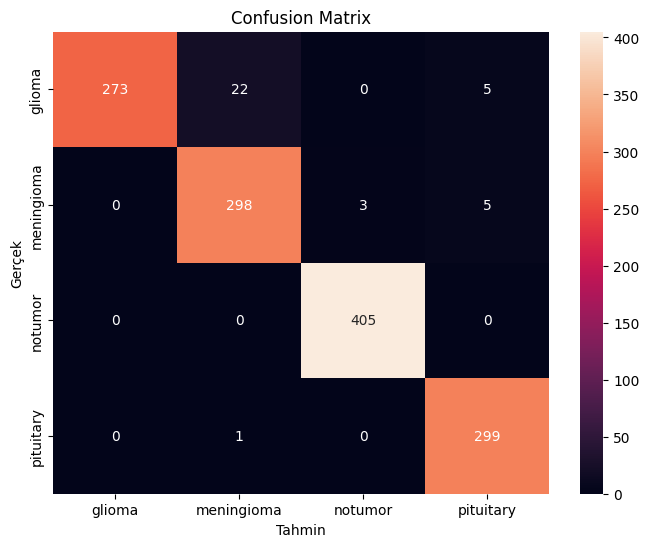

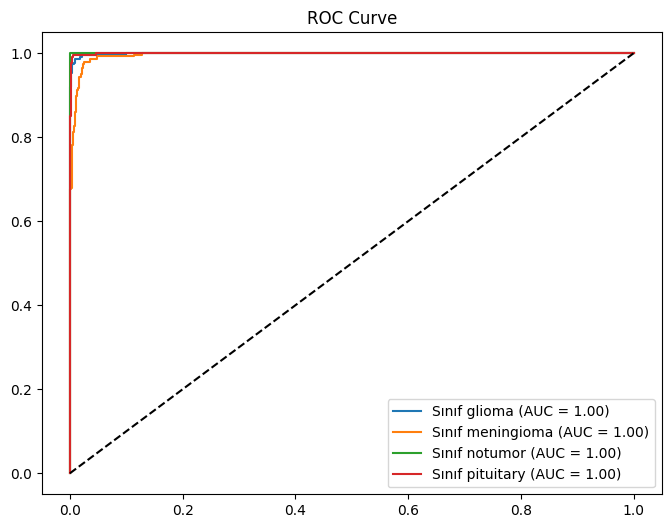

In [15]:
# 8. Grafikler
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title("Confusion Matrix")
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()

# ROC Curve
plt.figure(figsize=(8,6))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(np.array(all_labels) == i, np.array(all_probs)[:, i])
    plt.plot(fpr, tpr, label=f'Sınıf {test_dataset.classes[i]} (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.legend()
plt.show()